In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import scipy.io
import pandas as pd
from skimage import color
from skimage import io
from skimage.transform import radon, iradon, iradon_sart, rescale
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
import math
import cv2
from sklearn import metrics
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
ctScans = scipy.io.loadmat('/content/drive/My Drive/CCE-AIMIA/ctscan_hw1.mat')
ctMasks = scipy.io.loadmat('/content/drive/My Drive/CCE-AIMIA/infmsk_hw1.mat')

In [3]:
(ms,ns,cs)= (ctScans['ctscan']).shape
(mm,nm,cm)= (ctMasks['infmsk']).shape
print((ms,ns,cs))
print((mm,nm,cm))

(512, 512, 3554)
(512, 512, 3554)


In [4]:
ctscansarray = []
ctmasksarray = []
for i in range(cm):
    ctscansarray.append((ctScans['ctscan'][:,:,i]))
    ctmasksarray.append((ctMasks['infmsk'][:,:,i]))

In [6]:
kmeansSeg_image = []
labels_reshaped = []
k = 3 # number of clusters (K)
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
for i in range(len(ctscansarray)):
  # reshape the image to a 2D array of pixels
  image = ctscansarray[i]
  ct_pixel_values = image.reshape(-1,1)
  # convert to float
  ct_pixel_values = np.float32(ct_pixel_values)
  #print(ct_pixel_values.shape)
  _, labels, (centers) = cv2.kmeans(ct_pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  # convert back to 8 bit values
  centers = np.uint8(centers)
  # flatten the labels array
  labels = labels.flatten()
  # convert all pixels to the color of the centroids
  segmented_image = centers[labels.flatten()]
  # reshape back to the original image dimension
  segmented = segmented_image.reshape(image.shape)
  kmeansSeg_image.append(segmented)
  labels_reshaped.append(labels.reshape(512,512))

In [26]:
tp = 0
tn = 0
fn = 0
fp = 0
Sensitivity = []
Specificity = []
Accuracy = []
Dice_score = []
(rows, columns) = (512, 512)
for m in range(len(ctmasksarray)):
	ground_truth = ctmasksarray[m]
	KsegLabels = labels_reshaped[m]
	for i in range(rows):
		for j in range(columns):
			if ground_truth[i][j] == 1 and KsegLabels[i][j] == 0:
				tp = tp + 1
			if ground_truth[i][j] == 2 and KsegLabels[i][j] == 2:
				tn = tn + 1
			if ground_truth[i][j] == 1 and KsegLabels[i][j] == 2:
				fn = fn + 1
			if ground_truth[i][j] == 2 and KsegLabels[i][j] == 0:
				fp = fp + 1

	try:
		TPR = float(tp)/(tp+fn)
		Sensitivity.append(TPR)
		FPR = float(tn)/(tn+fp)
		Specificity.append(FPR)
		Acc = ((tp+tn)/(tp+tn+fn+fp))*100
		Accuracy.append(Acc)
		dice = float(2*tp)/((2*tp)+fp+fn)
		Dice_score.append(dice)
	except ZeroDivisionError:
		TPR=0
	

In [42]:
Sum_Sensitivity=0
Sum_Specificty=0
Sum_Accuracy=0
Sum_Dice_score=0
print ('\n************Average Accuracy, Sensitivity, Specificity, Avg Dice_Socre********')

for i in range(len(Sensitivity)):
  Sum_Sensitivity+=Sensitivity[i]
  Sum_Specificty+=Specificity[i]
  Sum_Accuracy+=Accuracy[i]
  Sum_Dice_score+=Dice_score[i]

Avg_sensitivity = Sum_Sensitivity/len(Sensitivity)
print("\nAverage Sensitivity is:",Avg_sensitivity)
Avg_Specificity = Sum_Specificty/len(Specificity)
print("\nAverage Specificity is:", Avg_Specificity)
Avg_Accuracy = Sum_Accuracy/len(Accuracy)
print("\nAverage Accuracy(%):",Avg_Accuracy)
Avg_Dice_score = Sum_Dice_score/len(Dice_score)
print("\nAverage Dice_score:",Avg_Dice_score)


************Average Accuracy, Sensitivity, Specificity, Avg Dice_Socre********

Average Sensitivity is: 0.4917266328796307

Average Specificity is: 0.4707865949677128

Average Accuracy(%): 47.322597631898546

Average Dice_score: 0.11304791992172793



************Ctslice, k-means segmentation, infection mask**********


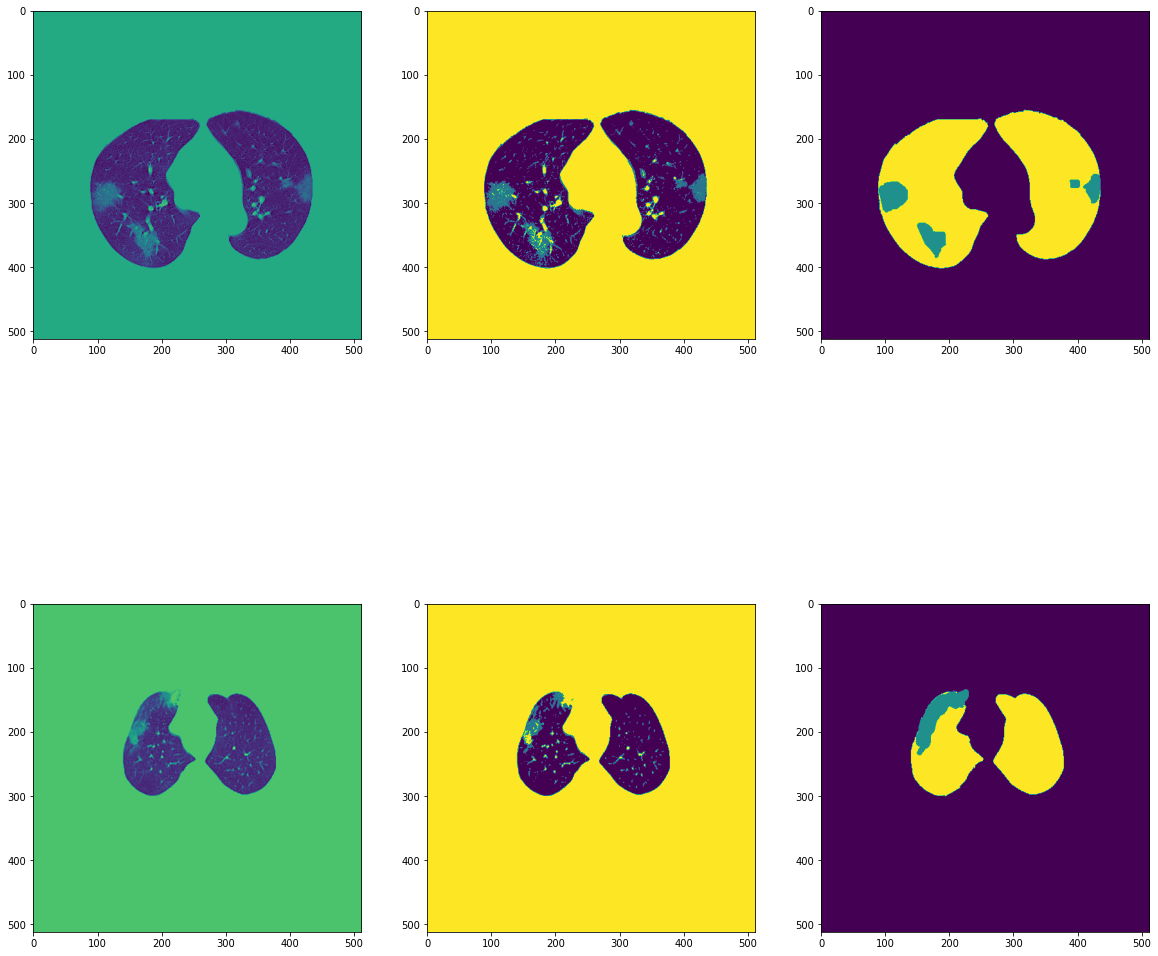

In [40]:
print ('\n************Ctslice, k-means segmentation, infection mask**********')
num1 = np.random.randint(0, len(kmeansSeg_image))
num2 = np.random.randint(0, len(kmeansSeg_image))
# show the image
fig, (ax1,ax2) = plt.subplots(2, 3,figsize=(20, 20))
ax1[0].imshow(ctscansarray[num1])
ax1[1].imshow(kmeansSeg_image[num1])
ax1[2].imshow((ctmasksarray[num1]))
ax2[0].imshow(ctscansarray[num2])
ax2[1].imshow(kmeansSeg_image[num2])
ax2[2].imshow((ctmasksarray[num2]))